# `multibeam` demo

This notebook provides a brief overview of the functionality implemented in the `multibeam` library.

## 0. Dependencies

Let's first import all the required packages for this overview:

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

import numpy as np
from scipy.stats import *
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob 
from skimage.io import imread, imsave

## 1. Dataset

The `data` directory of the repository contains a set of 10 test images, acquired using a SoundMetrics DIDSON, which we'll use to demonstrate the different functions in this package. Pings are typically stored as simple PNG images, where each column corresponds to a sonar beam, and each row corresponds to a range value ("polar" image).

In [2]:
image_list = sorted(glob('../data/dataset-1/*raw.png'))
print len(image_list)

10


We use `JSON` to store the sonar configuration. For the test images, this is stored in the `didson.json` file. Note that as sonar configuration can change over time, it is usually best to save each sonar ping as a PNG image and JSON file.

In [3]:
from sonar import Sonar

didson = Sonar();
didson.load_config('../data/DIDSON/didson.json')
didson.print_config()
# didson.__compute_lookup__(0.02)


# print didson.k_a2b
# print didson.k_b2a

Range: 0.75 - 9.75
FOV: 0.502862655531
Beams: 96
Bins: 512
1/SNR: 0.002
Rx gain: 20.0


In [4]:
print didson.beam(np.deg2rad(-69))


94


The configuration file can also store the sonar's beam pattern and taper function:

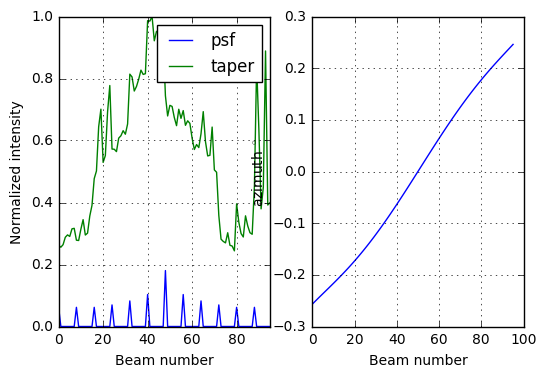

In [5]:
plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
plt.plot(didson.psf[0,:], label='psf')
plt.plot(didson.taper,label='taper')
plt.grid()
plt.xlabel('Beam number')
plt.ylabel('Normalized intensity')
plt.xlim([0, 95])
plt.legend()

plt.subplot(1,2,2)
plt.plot(didson.azimuths)
plt.title('')
plt.xlabel('Beam number')
plt.ylabel(r'azimuth ${}^\circ$')
plt.grid()
plt.show()

## 2. Pre-processing

The type of pre-processing steps supported by this package are intended to address:
 * beam-pattern effects (deconvolution, angular gain)
 * attenuation (radial gain)
 
In addition, conversion from polar to Cartesian image is also supported via `to_cart`

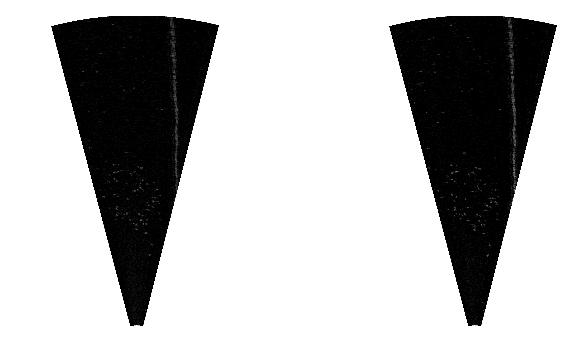

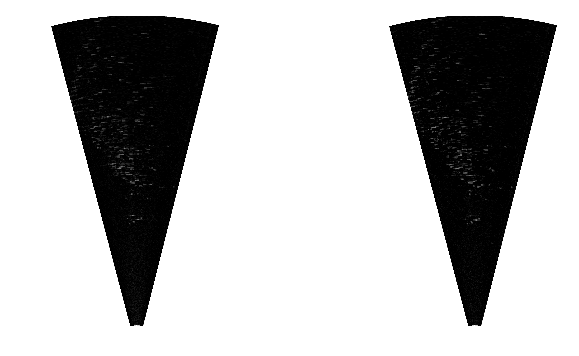

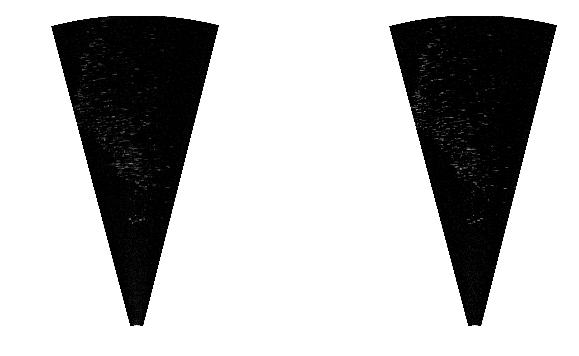

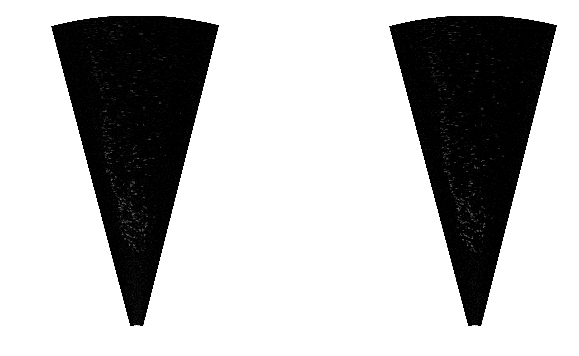

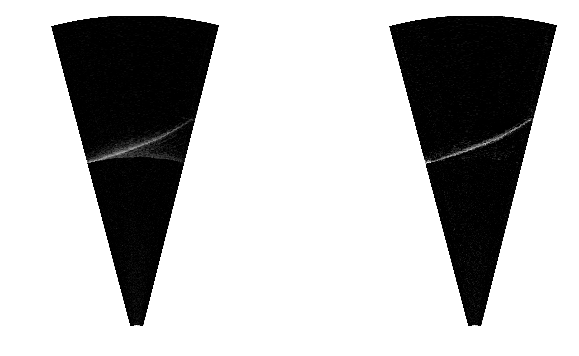

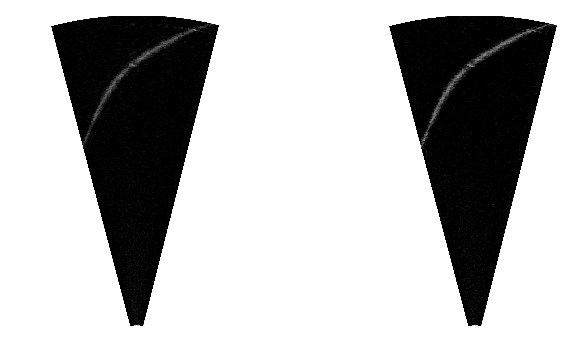

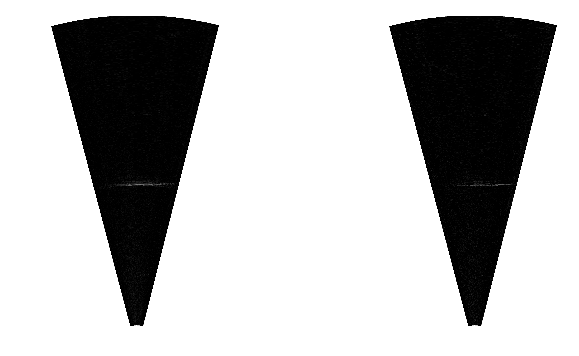

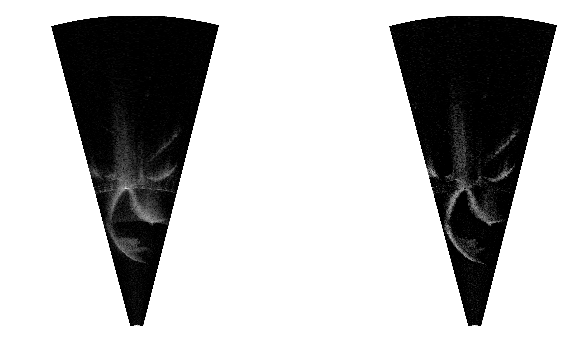

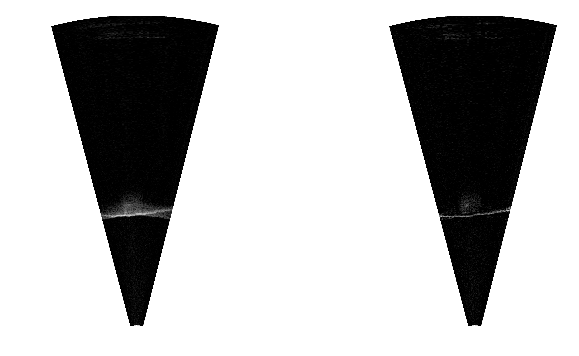

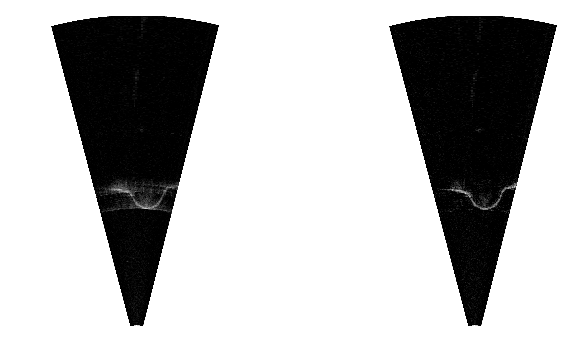

In [6]:
for idx in range(0, len(image_list)):
    ping_raw = imread(image_list[idx], as_grey=True).astype(np.float64)
    ping_raw/=255.0
    ping_raw_c = didson.to_cart(ping_raw, 1.0)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(np.flipud(ping_raw_c) ,vmax=1.0,cmap='gray')
    plt.axis('off')
    
    ping_deconv = didson.preprocess(ping_raw, False)
#     ping_deconv = np.copy(ping_raw)
    ping_deconv_c = didson.to_cart(ping_deconv, 1.0)
    
    plt.subplot(1,2,2)
    plt.imshow(np.flipud(ping_deconv_c),vmax=1.0, cmap='gray')
    plt.axis('off')
    
#     imsave('demo-ping_'+str(idx)+'_raw_polar.png',(255*ping_raw).astype(np.uint8))
#     imsave('demo-ping_'+str(idx)+'_deconv_polar.png',(255*ping_deconv).astype(np.uint8))

    imsave('demo-ping_'+str(idx)+'_raw.png',(255*ping_raw_c).astype(np.uint8))
    imsave('demo-ping_'+str(idx)+'_deconv.png',(255*ping_deconv_c).astype(np.uint8))


## 3. Mixture Model Estimation 


/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/scipy/optimize/optimize.py:562: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


kld: 0.00280930083721
theta: [ 0.29003441  0.02218744  0.02652637  0.14635049]


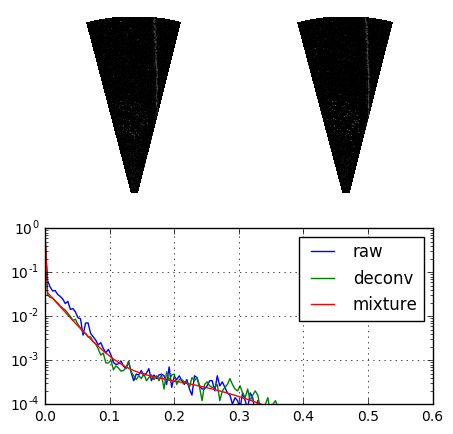

kld: 0.00227571924169
theta: [ 0.29497075  0.01912157  0.02740227  0.15886923]


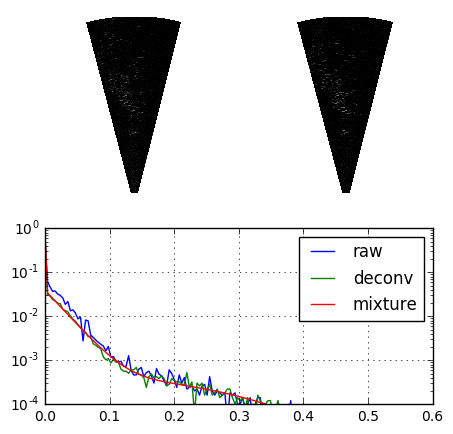

kld: 0.00181661789235
theta: [ 0.28804567  0.02167154  0.02743368  0.15000472]


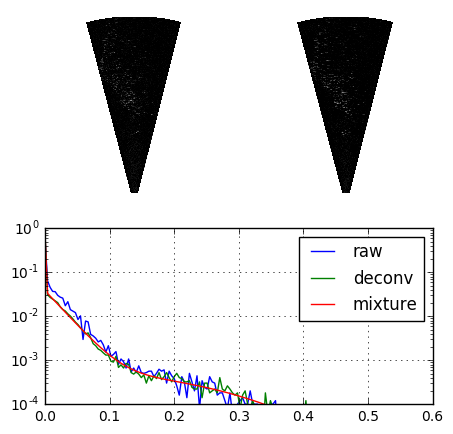

kld: 0.00179897814128
theta: [ 0.28797699  0.02089344  0.02344692  0.13860399]


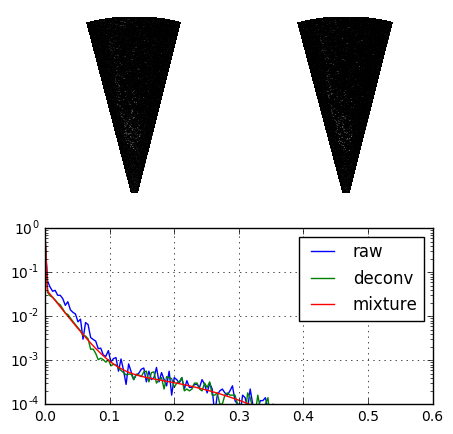

kld: 0.00284261821646
theta: [ 0.29838624  0.01183951  0.03077072  0.25108318]


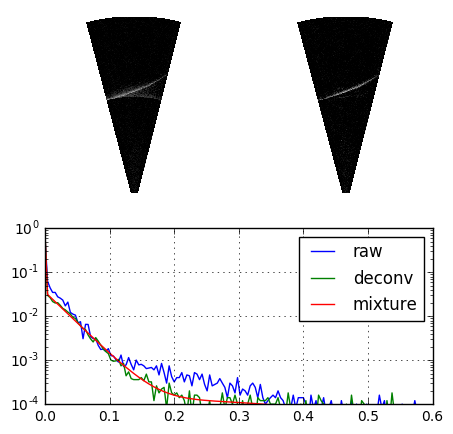

kld: 0.00281924993768
theta: [ 0.28679876  0.02139272  0.02598486  0.18126883]


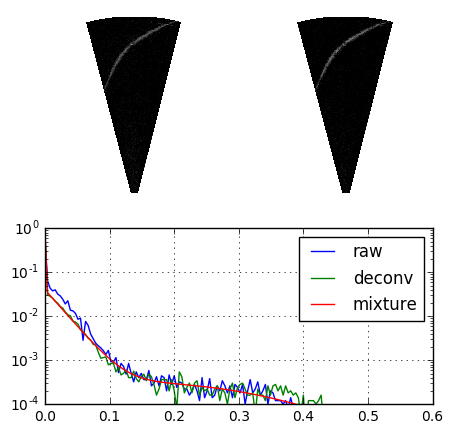

kld: 0.00311925779154
theta: [ 0.31357572  0.00161494  0.0280153   0.19654473]


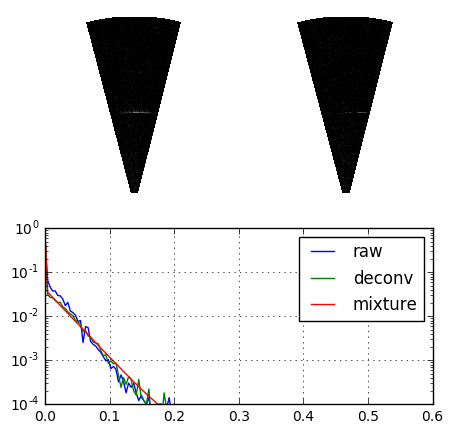

kld: 0.00252500820944
theta: [ 0.26216916  0.08829122  0.04841223  0.20544499]


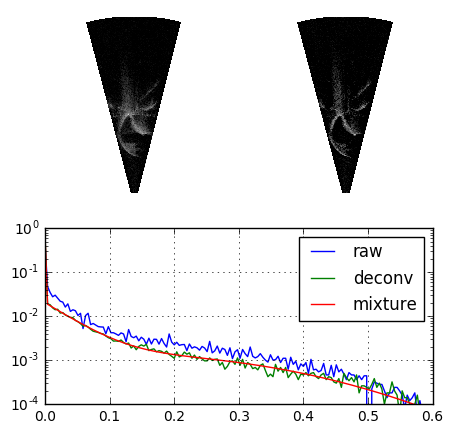

kld: 0.00373965011185
theta: [ 0.3078041   0.01233105  0.04450952  0.27111378]


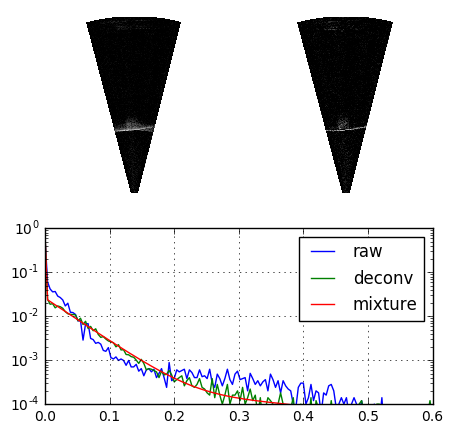

kld: 0.0024574364906
theta: [ 0.30944141  0.01367877  0.03424274  0.24187639]


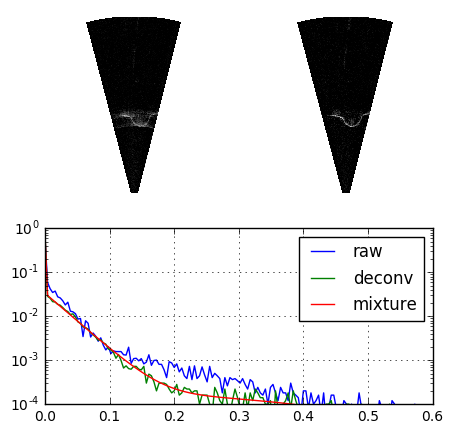

In [7]:
import utils
intensity = np.linspace(0,1.0,256)
for idx in range(0,len(image_list)):
    ping_raw = imread(image_list[idx], as_grey=True)/255.0
    ping_deconv = didson.deconvolve(ping_raw)
    # compute mixture model
    p_emp, p_mix, theta, kld = utils.get_mixture(ping_deconv)

    if np.any(theta<=0):
        print 'WARNING: invalid parameters!'
        print 'image:', idx
        continue
    else:
        print 'kld:', kld
        print 'theta:', theta
        

    # plot mixture model
    plt.figure(figsize=(5,5))
    plt.subplot(2,2,1)
    plt.imshow(np.flipud(didson.to_cart(ping_raw,1.0)),cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,2,2)
    plt.imshow(np.flipud(didson.to_cart(ping_deconv,1.0)),cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,1,2)
    hist, bins = np.histogram(ping_raw.flatten(),intensity)
    plt.plot(bins[:-1], hist/(0.0+np.sum(hist)),label='raw')

    plt.plot(bins, p_emp, label='deconv')
    plt.plot(bins, p_mix, label='mixture')
    plt.legend()
    plt.yscale('log')
    plt.grid()
    plt.ylim([1e-4,1e0])
    plt.xlim([0,0.6])
    
    plt.show()
#     plt.savefig('mixture_'+str(idx)+'.png')

In [ ]:
len(p_emp)

## 4. Segmentation

### 4.1 _maximum a posteriori_ (MAP)

In [ ]:
import utils

In [ ]:
idx = 4
image = (1/255.0)*imread(image_list[idx],as_grey = True)
# didson.loadConfig(test_config_list[idx])
didson.noise=0.001
image_d = didson.deconvolve(image)
image_d = didson.removeTaper(image_d)

(p,k) = utils.get_mixture_parameters(image_d)
print p
image_bin = utils.segment_map(image_d, p[0],p[1],p[2],p[3])
# TODO: assert parameters are sane!

In [ ]:
import utils
intensity = np.linspace(0,1.0,256)
for idx in range(0,len(image_list)):
    ping_raw = imread(image_list[idx], as_grey=True)/255.0
    ping_deconv = didson.deconvolve(ping_raw)
    ping_ft = utils.segment_ping_threshold(ping_deconv,0.3)
    ping_map, _ = utils.segment_ping_map(ping_deconv)

    plt.figure(figsize=(12,6))
    plt.subplot(1,4,1)
    plt.imshow(np.flipud(didson.to_cart(ping_raw,1.0)),cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(np.flipud(didson.to_cart(ping_deconv,1.0)),cmap='gray')
    plt.axis('off')
    plt.title('Pre-processed')

    plt.subplot(1,4,3)
    plt.imshow(np.flipud(didson.to_cart(ping_ft,1.0)),cmap='gray')
    plt.axis('off')
    plt.title('Fixed threshold')
    
    plt.subplot(1,4,4)
    plt.imshow(np.flipud(didson.to_cart(ping_map,1.0)),cmap='gray')
    plt.axis('off')
    plt.title('MAP')
    
#     plt.savefig('results_'+str(idx)+'_map.png')


In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
ic = didson.to_cart(image,1.0)
plt.imshow(ic.transpose(),vmin=0,vmax=1,cmap='gray')
plt.axis('off')

plt.subplot(4,1,2)
icd = didson.to_cart(image_d,1.0)
plt.imshow(icd.transpose(), vmin=0, vmax=1,cmap='gray')
plt.axis('off') 

# TODO: threshold image

plt.subplot(4,1,4)
icb = didson.to_cart(image_bin,1.0)
plt.imshow(icb.transpose(), vmin=0, vmax=1,cmap='gray')
plt.axis('off')
# plt.savefig(str(idx)+'_map.png')


### 4.2 2D Markov Random Field (MRF)

**TODO**

### 4.3 1D Markov Random Field (MRF)

**TODO**